In [211]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [235]:
import matplotlib.pyplot as plt
import catboost
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.stem.snowball import SnowballStemmer
import string
from string import punctuation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [213]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [214]:
data = pd.read_csv('/kaggle/input/train-csv/train.csv')
data_2 = pd.read_csv('/kaggle/input/bank-sentiments/bank-sentiment.csv')
data_bert = pd.read_csv('/kaggle/input/sentiment4/sentiment.csv')

In [215]:
data_bert

,ID,sent_id,Neutral,Positive,Negative
0,107177,0,0.084431,0.002650,0.912919
1,107177,1,0.567404,0.031640,0.400956
2,107177,2,0.703519,0.046432,0.250050
3,107177,3,0.257969,0.005552,0.736479
4,107177,4,0.007072,0.017009,0.975919
...,...,...,...,...,...
7300765,460503,11,0.094416,0.012390,0.893194
7300766,460503,12,0.116461,0.288670,0.594868
7300767,460503,13,0.040278,0.006100,0.953621
7300768,460503,14,0.061532,0.016173,0.922296


In [216]:
bank_data = pd.read_csv('/kaggle/input/hataton/HSE Data Science Hack /banki.csv')

In [217]:
data

,Unnamed: 0,sentence,1category,2category,sentiment
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+
...,...,...,...,...,...
19356,8004,Никогда и ни в коем случае не открывайте счет ...,Communication,NaN,−
19357,18182,ТИ откровенно забили на качество и развивают с...,Quality,NaN,−
19358,744,"Я считаю, это прорыв и лидерство финансовых ус...",?,NaN,+
19359,6220,"Писал мужчина очень доходчиво, не финансовым я...",Communication,NaN,+


In [218]:
data_bert.shape

(7300770, 5)

In [219]:
data_bert.iloc[0].ID

107177.0

In [220]:
data_bert.ID.unique().shape

(588183,)

In [221]:
for i in range(data_bert.shape[0]):
    string = data_bert.iloc[i]

KeyboardInterrupt: 

In [ ]:
data_2

In [ ]:
data.head()

In [ ]:
data['2category'].value_counts(dropna=False)

In [ ]:
data['1category'].value_counts(dropna=False)

In [ ]:
data.isna().sum()

In [222]:
data = data.fillna('nans')

In [223]:
data.drop('Unnamed: 0', axis=1, inplace=True)

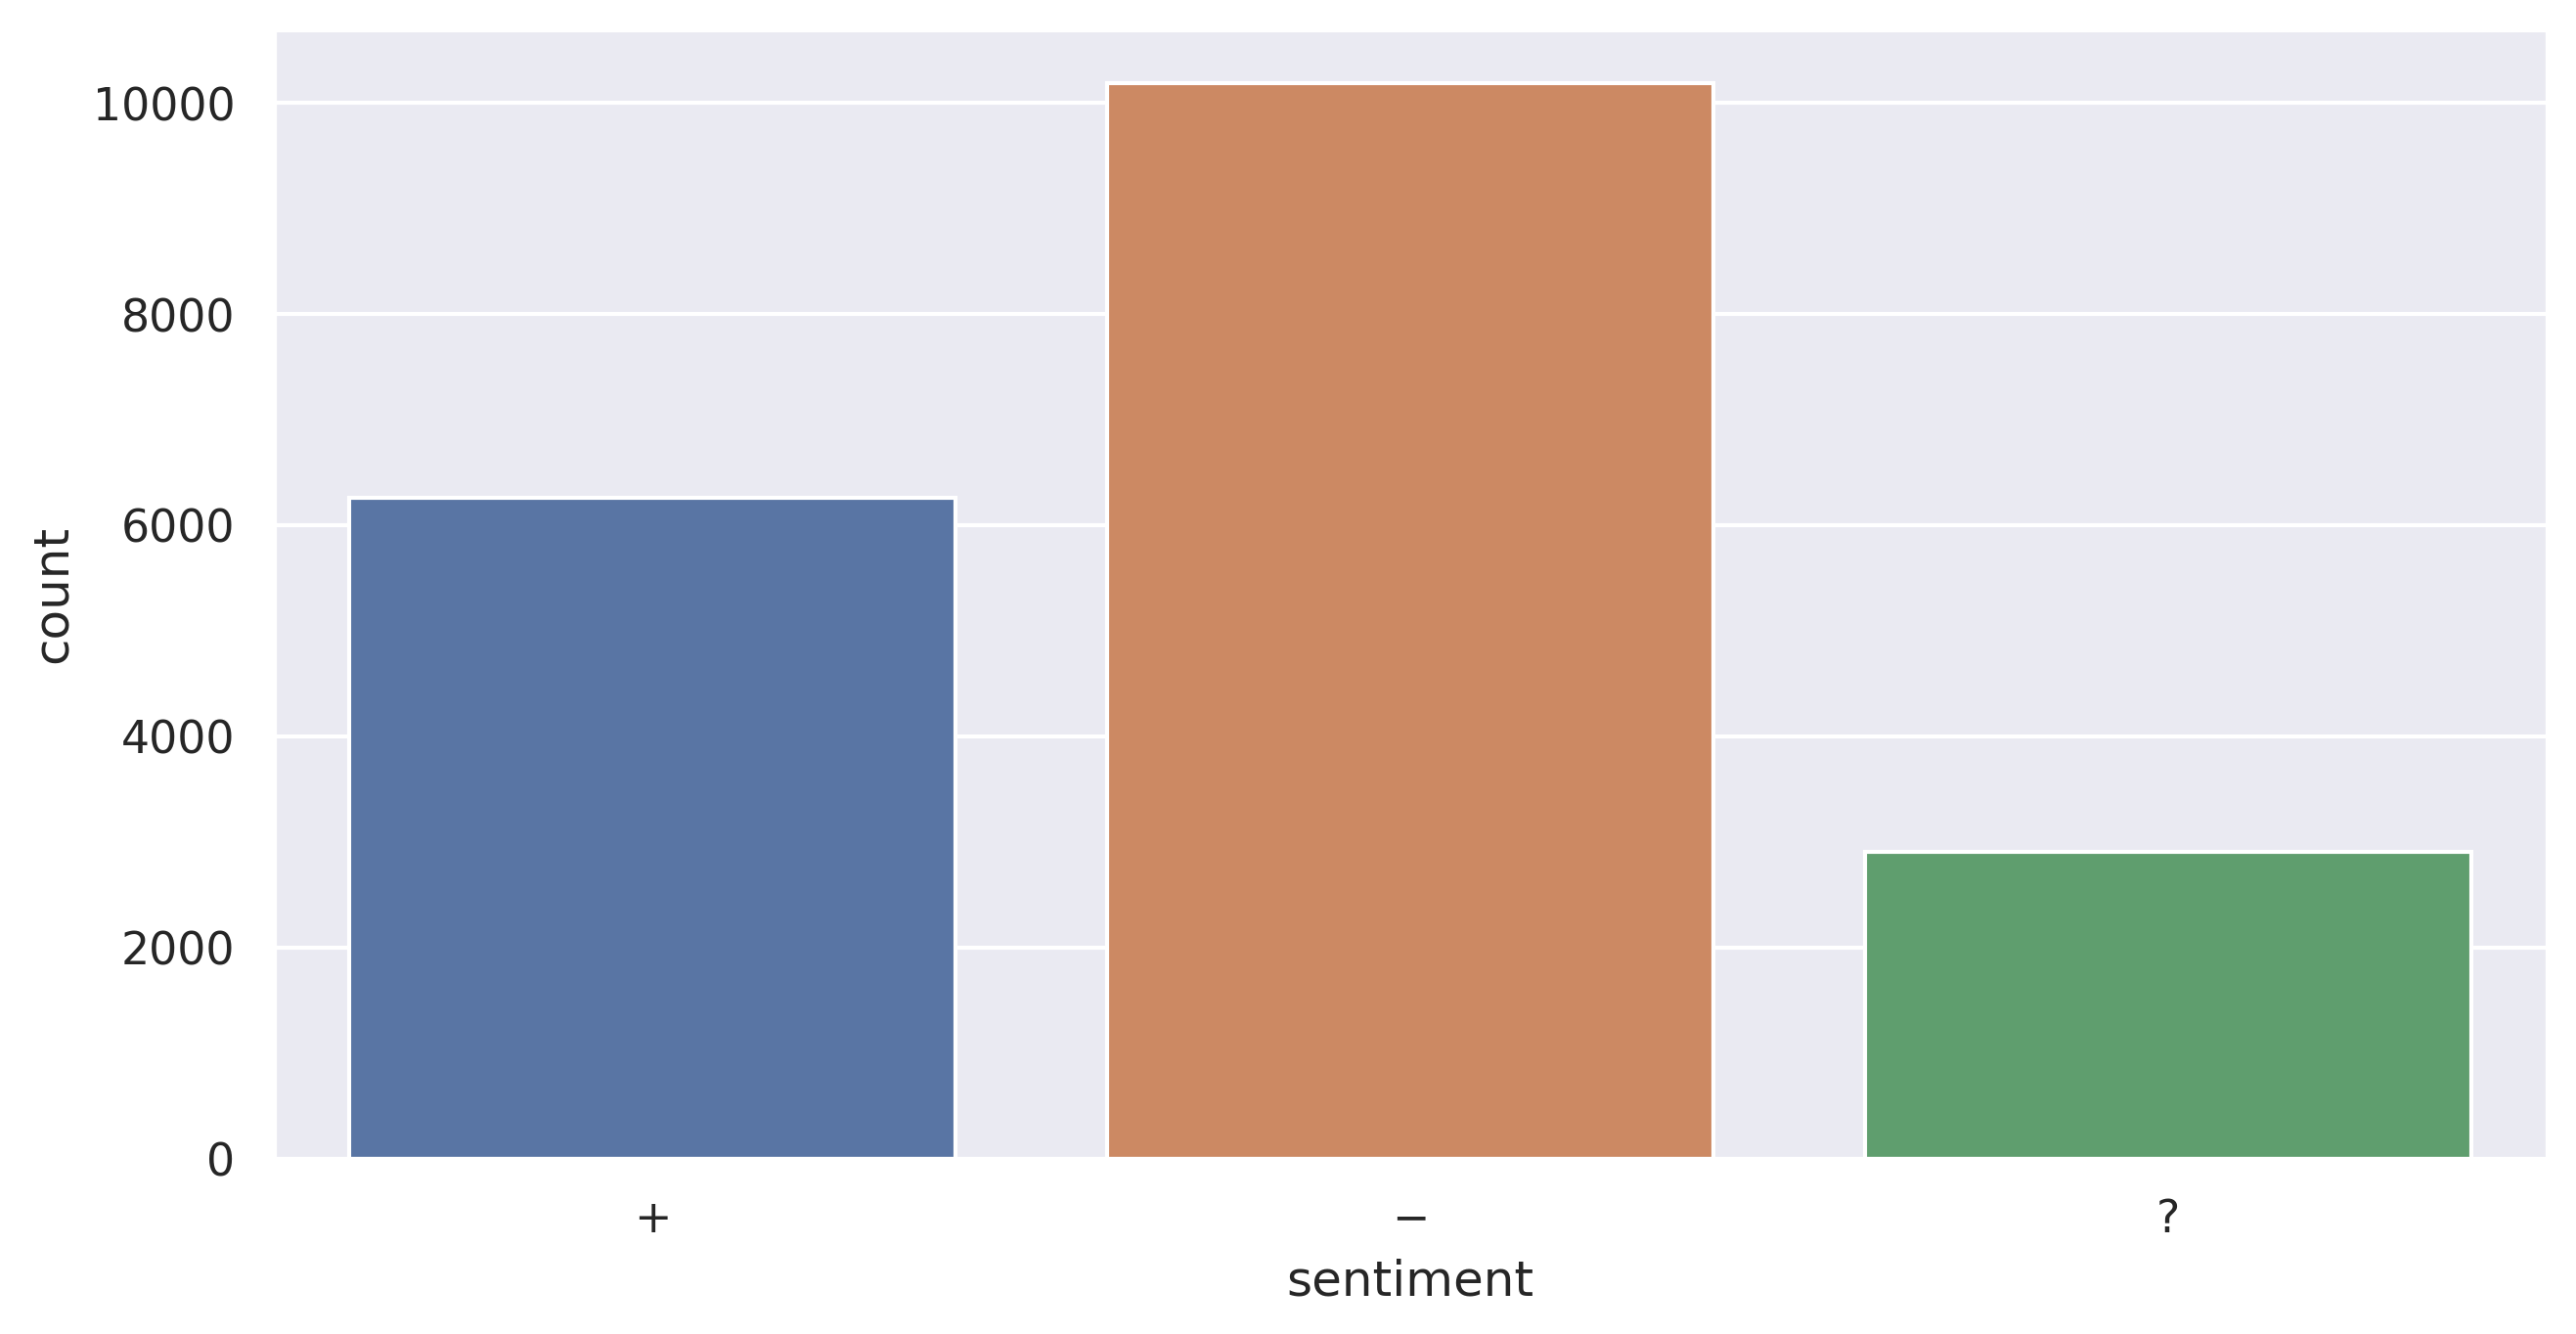

In [224]:
plt.figure(figsize=(10, 5), dpi=300)
sns.set_theme(style="darkgrid")
sns.countplot(x=data['sentiment'])
None

In [225]:
data['sentiment'][data['sentiment']=='+']=1
data['sentiment'][data['sentiment']=='?']=0
data['sentiment'][data['sentiment']=='−']=-1
data['sentiment'].unique()

array([1, -1, 0], dtype=object)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    data['sentence'], data['sentiment'], test_size=0.2, random_state=42)

In [227]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [228]:
def tok(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

In [229]:
vect2 = HashingVectorizer(ngram_range=(1, 5), tokenizer=tok)

In [230]:
bow3 = vect2.fit_transform(X_train)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [231]:
bow3_test = vect2.transform(X_test)
bow3.shape

(15488, 1048576)

In [237]:
#scaler = MaxAbsScaler()
scaler = StandardScaler(with_mean=False)
bow3 = scaler.fit_transform(bow3)
bow3_test = scaler.transform(bow3_test)

In [238]:
C = [10**(-n) for n in range(-3, 10)]
penalties = ['l1', 'l2']
score_0 = 0
for i in tqdm(range(len(C))):
    for penalty in penalties:
        lgr = LogisticRegression(max_iter=1000,
                                 random_state=42, C=C[i],
                                 penalty=penalty,
                                 solver='liblinear')
        lgr.fit(bow3, y_train)
        pred_proba = lgr.predict_proba(bow3_test)
        score = roc_auc_score(y_test, pred_proba, multi_class='ovr')
        if score > score_0:
            score_0 = score
            C_ = C[i]
            p = penalty

100%|██████████| 13/13 [10:17<00:00, 47.52s/it]


In [239]:
C_, p

(0.1, 'l1')

In [240]:
lgr_best = LogisticRegression(max_iter=1000, random_state=42, C=C_, penalty=p, solver='liblinear')
lgr_best.fit(bow3, y_train)
pred_proba = lgr_best.predict_proba(bow3_test)

In [241]:
print(roc_auc_score(y_test, pred_proba, multi_class='ovr'))

0.9362814463494482


In [196]:
l2_reg = range(6)
depth = range(1, 17)
lr = 1e-4*np.array(range(1, 100, 10))

In [198]:
score0 = 0
best_params = []
for i in tqdm(range(len(l2_reg)), desc='Работаем, Братья: ', position=0):
    for j in tqdm(range(len(depth)), desc='Работаем, Братья: ', position=1, leave=False):
        for k in tqdm(range(len(lr)), desc='Работаем, Братья: ', position=2, leave=False):
            model = CatBoostClassifier(
                                        learning_rate=lr[k],
                                        depth=depth[j],
                                        l2_leaf_reg=l2_reg[i],
                                        iterations=1000,
                                        random_seed=42,
                                        loss_function='MultiClass',
                                        verbose=False
                                      )
            model.fit(bow3, y_train)
            pred_proba = model.predict_proba(bow3_test)
            score = roc_auc_score(y_test, pred_proba, multi_class='ovr')
            print(f'roc_auc_score: {score},\n lr={lr[k]},\n d={depth[j]}, \n l2={l2_reg[i]}')
            if score > score0:
                best_params={'l2':l2_reg[i],
                                    'depth': depth[j],
                                    'learning_rate': lr[k]}

Работаем, Братья:   0%|          | 0/16 [00:00<?, ?it/s]

Работаем, Братья:   0%|          | 0/10 [00:00<?, ?it/s]

Работаем, Братья:  10%|█         | 1/10 [02:43<24:33, 163.73s/it]

roc_auc_score: 0.651587715152636,
 lr=0.0001,
 d=1, 
 l2=0




Работаем, Братья:  20%|██        | 2/10 [05:28<21:52, 164.10s/it]

roc_auc_score: 0.7313002593069511,
 lr=0.0011,
 d=1, 
 l2=0




Работаем, Братья:  30%|███       | 3/10 [08:11<19:06, 163.73s/it]

roc_auc_score: 0.7425815569287461,
 lr=0.0021000000000000003,
 d=1, 
 l2=0




Работаем, Братья:  40%|████      | 4/10 [10:55<16:22, 163.82s/it]

roc_auc_score: 0.7532944971909167,
 lr=0.0031000000000000003,
 d=1, 
 l2=0




Работаем, Братья:  50%|█████     | 5/10 [13:38<13:38, 163.67s/it]

roc_auc_score: 0.7611920726006648,
 lr=0.0041,
 d=1, 
 l2=0




Работаем, Братья:  60%|██████    | 6/10 [16:23<10:55, 163.87s/it]

roc_auc_score: 0.7709411642785978,
 lr=0.0051,
 d=1, 
 l2=0




Работаем, Братья:  70%|███████   | 7/10 [19:08<08:13, 164.55s/it]

roc_auc_score: 0.7760710151484496,
 lr=0.0061,
 d=1, 
 l2=0




Работаем, Братья:  80%|████████  | 8/10 [21:55<05:30, 165.33s/it]

roc_auc_score: 0.7804008719083506,
 lr=0.0071,
 d=1, 
 l2=0




Работаем, Братья:  90%|█████████ | 9/10 [24:43<02:46, 166.14s/it]

roc_auc_score: 0.7845666337492007,
 lr=0.0081,
 d=1, 
 l2=0




Работаем, Братья: 100%|██████████| 10/10 [27:32<00:00, 166.93s/it]

                                                                  
Работаем, Братья:   6%|▋         | 1/16 [27:32<6:53:08, 1652.58s/it]

roc_auc_score: 0.7866156776140577,
 lr=0.0091,
 d=1, 
 l2=0




Работаем, Братья:   0%|          | 0/10 [00:00<?, ?it/s]

Работаем, Братья:  10%|█         | 1/10 [05:16<47:30, 316.76s/it]

roc_auc_score: 0.7590453945958959,
 lr=0.0001,
 d=2, 
 l2=0




Работаем, Братья:  20%|██        | 2/10 [10:29<41:56, 314.54s/it]

roc_auc_score: 0.7591490676351706,
 lr=0.0011,
 d=2, 
 l2=0




Работаем, Братья:  30%|███       | 3/10 [15:36<36:17, 311.02s/it]

roc_auc_score: 0.7678298225721337,
 lr=0.0021000000000000003,
 d=2, 
 l2=0




                                                                 
Работаем, Братья:   0%|          | 0/6 [47:14<?, ?it/s]             


KeyboardInterrupt: 

In [ ]:
best_params